In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from scipy import stats
import seaborn as sns

sns.set(rc={'figure.figsize':(15,10)})

In [2]:
df = pd.read_csv('events_up_to_01062018.csv', low_memory = False, parse_dates = ['timestamp'], infer_datetime_format = True,
                    dtype = {'event': 'category','condition': 'category','storage': 'category', 'color': 'category', 'staticpage': 'category', 'campaign_source': 'category', 'search_engine': 'category', 'channel': 'category', 'new_vs_returning': 'category', 'region': 'category', 'country': 'category', 'device_type': 'category'})
labels = pd.read_csv('labels_training_set.csv', low_memory = False).set_index('person')

In [6]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    target = 'label'
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Print model report:
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [119]:
dfPredictor = pd.DataFrame(df['person'].unique())
dfPredictor.columns = ['person']
dfPredictor = dfPredictor.set_index('person')

#ult60Dias = df.loc[df['timestamp'] > pd.to_datetime('01-04-2018')]
ult30Dias = df.loc[(df['timestamp'] > pd.to_datetime('01-05-2018'))]# & (df['timestamp'] > pd.to_datetime('15-05-2018'))]
ult15Dias = df.loc[(df['timestamp'] > pd.to_datetime('15-05-2018'))]# & (df['timestamp'] > pd.to_datetime('25-05-2018'))]
ult5Dias = df.loc[(df['timestamp'] > pd.to_datetime('25-05-2018'))]# & (df['timestamp'] > pd.to_datetime('31-05-2018'))]
ultDia = df.loc[df['timestamp'] > pd.to_datetime('31-05-2018')]




#
#       Compras o conversiones
#

#checkoutsPorPersonaUlt60Dias = ult60Dias.loc[ult60Dias['event'] == 'checkout']['person'].value_counts().to_frame()
#checkoutsPorPersonaUlt60Dias.columns = ['checkoutsUlt60Dias']
#conversionesPorPersonaUlt60Dias = ult60Dias.loc[ult60Dias['event'] == 'conversion']['person'].value_counts().to_frame()
#conversionesPorPersonaUlt60Dias.columns = ['conversionesUlt60Dias']

checkoutsPorPersonaUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt30Dias.columns = ['checkoutsUlt30Dias']
conversionesPorPersonaUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt30Dias.columns = ['conversionesUlt30Dias']

checkoutsPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt15Dias.columns = ['checkoutsUlt15Dias']
conversionesPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt15Dias.columns = ['conversionesUlt15Dias']

checkoutsPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt5Dias.columns = ['checkoutsUlt5Dias']
conversionesPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt5Dias.columns = ['conversionesUlt5Dias']

checkoutsPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUltDia.columns = ['checkoutsUltDia']
conversionesPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUltDia.columns = ['conversionesUltDia']

#dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt60Dias, how = 'left', on = 'person').fillna(value = 0)
#dfPredictor = dfPredictor.join(conversionesPorPersonaUlt60Dias, how = 'left', on = 'person').fillna(value = 0)

dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt30Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt30Dias, how = 'left', on = 'person').fillna(value = 0)

dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)

dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)

dfPredictor = dfPredictor.join(checkoutsPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)

#
#        Canal de origen
#

visitasUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'visited site']
visitasUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'visited site']
visitasUltDia = ultDia.loc[ultDia['event'] == 'visited site']

# Pago

paidUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUlt15Dias.columns = ['CanalPagoUlt15Dias']

paidUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUlt5Dias.columns = ['CanalPagoUlt5Dias']

paidUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUltDia.columns = ['CanalPagoUltDia']

#dfPredictor = dfPredictor.join(paidUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(paidUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
#dfPredictor = dfPredictor.join(paidUltDia, how = 'left', on = 'person').fillna(value = 0)

# Organic

organicUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUlt15Dias.columns = ['CanalOrganicoUlt15Dias']

organicUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUlt5Dias.columns = ['CanalOrganicoUlt5Dias']

organicUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUltDia.columns = ['CanalOrganicoUltDia']

#dfPredictor = dfPredictor.join(organicUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(organicUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
#dfPredictor = dfPredictor.join(organicUltDia, how = 'left', on = 'person').fillna(value = 0)

# Direct

directUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt15Dias.columns = ['CanalDirectoUlt15Dias']

directUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt5Dias.columns = ['CanalDirectoUlt5Dias']

directUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Direct']['person'].value_counts().to_frame()
directUltDia.columns = ['CanalDirectoUltDia']

dfPredictor = dfPredictor.join(directUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(directUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(directUltDia, how = 'left', on = 'person').fillna(value = 0)

# Referral

referralUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUlt15Dias.columns = ['CanalReferidoUlt15Dias']

referralUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUlt5Dias.columns = ['CanalReferidoUlt5Dias']

referralUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUltDia.columns = ['CanalReferidoUltDia']

dfPredictor = dfPredictor.join(referralUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(referralUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(referralUltDia, how = 'left', on = 'person').fillna(value = 0)

# Social

socialUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Social']['person'].value_counts().to_frame()
socialUlt15Dias.columns = ['CanalSocialUlt15Dias']

socialUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Social']['person'].value_counts().to_frame()
socialUlt5Dias.columns = ['CanalSocialUlt5Dias']

socialUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Social']['person'].value_counts().to_frame()
socialUltDia.columns = ['CanalSocialUltDia']

#dfPredictor = dfPredictor.join(socialUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
#dfPredictor = dfPredictor.join(socialUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
#dfPredictor = dfPredictor.join(socialUltDia, how = 'left', on = 'person').fillna(value = 0)

# Email

emailUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Email']['person'].value_counts().to_frame()
emailUlt15Dias.columns = ['CanalEmailUlt15Dias']

emailUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Email']['person'].value_counts().to_frame()
emailUlt5Dias.columns = ['CanalEmailUlt5Dias']

emailUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Email']['person'].value_counts().to_frame()
emailUltDia.columns = ['CanalEmailUltDia']

#dfPredictor = dfPredictor.join(emailUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
#dfPredictor = dfPredictor.join(emailUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
#dfPredictor = dfPredictor.join(emailUltDia, how = 'left', on = 'person').fillna(value = 0)

#
#  Visitas
#

visitasUlt15DiasPorPersona = visitasUlt15Dias['person'].value_counts().to_frame()
visitasUlt15DiasPorPersona.columns = ['CantVisitasUlt15Dias']

visitasUlt5DiasPorPersona = visitasUlt5Dias['person'].value_counts().to_frame()
visitasUlt5DiasPorPersona.columns = ['CantVisitasUlt5Dias']

visitasUltDiaPorPersona = visitasUltDia['person'].value_counts().to_frame()
visitasUltDiaPorPersona.columns = ['CantVisitasUltDia']

dfPredictor = dfPredictor.join(visitasUlt15DiasPorPersona, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(visitasUlt5DiasPorPersona, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(visitasUltDiaPorPersona, how = 'left', on = 'person').fillna(value = 0)

#
#  Viewed product
#

viewedProductPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUlt15Dias.columns = ['viewedProductUlt15Dias']

viewedProductPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUlt5Dias.columns = ['viewedProductUlt5Dias']

viewedProductPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUltDia.columns = ['viewedProductUltDia']

dfPredictor = dfPredictor.join(viewedProductPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(viewedProductPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(viewedProductPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)

# Separo los labels locales
dfPredictorLocal = dfPredictor.join(labels, how = 'inner')

In [120]:
X, y = dfPredictorLocal.iloc[:,:-1], dfPredictorLocal.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [121]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                            colsample_bytree = 0.3, learning_rate = 0.05,
                            max_depth = 5, n_estimators = 140,
                            booster = 'gbtree')
xg_reg.fit(X_train,y_train, eval_metric='auc')
preds = xg_reg.predict(X_test)
#preds[preds < 0.009] = 0
roc_auc_score(y_test, preds)

0.84690011053090486

Paid, Organic, Direct, Referral, Social, Email, Unknown

In [124]:
kaggle = pd.read_csv('trocafone_kaggle_test.csv', low_memory = False)
kaggle = kaggle.set_index('person')
dfPredictorSubmit = dfPredictor.join(kaggle, how = 'inner')
predsSubmit = xgb1.predict(dfPredictorSubmit)
predsSubmit[predsSubmit < 0 ] = 0
predsSubmit[predsSubmit > 1] = 1
dfPredictorSubmit['label'] = predsSubmit
dfPredictorSubmit['label'].to_frame().to_csv('submit.csv')

8c6d264d 1 43790d8f 1 429c8732 0 911a21cb 1

In [266]:
df.loc[df['person'] == '43790d8f']

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
31,2018-05-18 00:29:42,viewed product,43790d8f,NaN,10378.0,Motorola Moto G4 Plus,Bom,32GB,Bambu,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,2018-05-18 00:27:16,viewed product,43790d8f,NaN,10378.0,Motorola Moto G4 Plus,Bom,32GB,Bambu,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,2018-05-18 00:26:47,viewed product,43790d8f,NaN,10464.0,Motorola Moto G4 Play,Excelente,16GB,Preto,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,2018-05-18 00:25:24,viewed product,43790d8f,NaN,318.0,iPhone 5s,Muito Bom,64GB,Prateado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,2018-05-18 00:24:52,viewed product,43790d8f,NaN,6791.0,Samsung Galaxy S5 New Edition Duos,Bom,16GB,Preto,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,2018-05-18 00:23:38,viewed product,43790d8f,NaN,12522.0,Motorola Moto G5,Excelente,32GB,Platinum,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,2018-05-18 00:23:22,viewed product,43790d8f,NaN,12522.0,Motorola Moto G5,Excelente,32GB,Platinum,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,2018-05-18 00:22:58,checkout,43790d8f,NaN,10378.0,Motorola Moto G4 Plus,Bom,32GB,Bambu,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,2018-05-18 00:29:27,viewed product,43790d8f,NaN,10408.0,Motorola Moto G4 Plus,Excelente,32GB,Preto Vermelho,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,2018-05-18 00:29:13,viewed product,43790d8f,NaN,10380.0,Motorola Moto G4 Plus,Excelente,32GB,Bambu,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


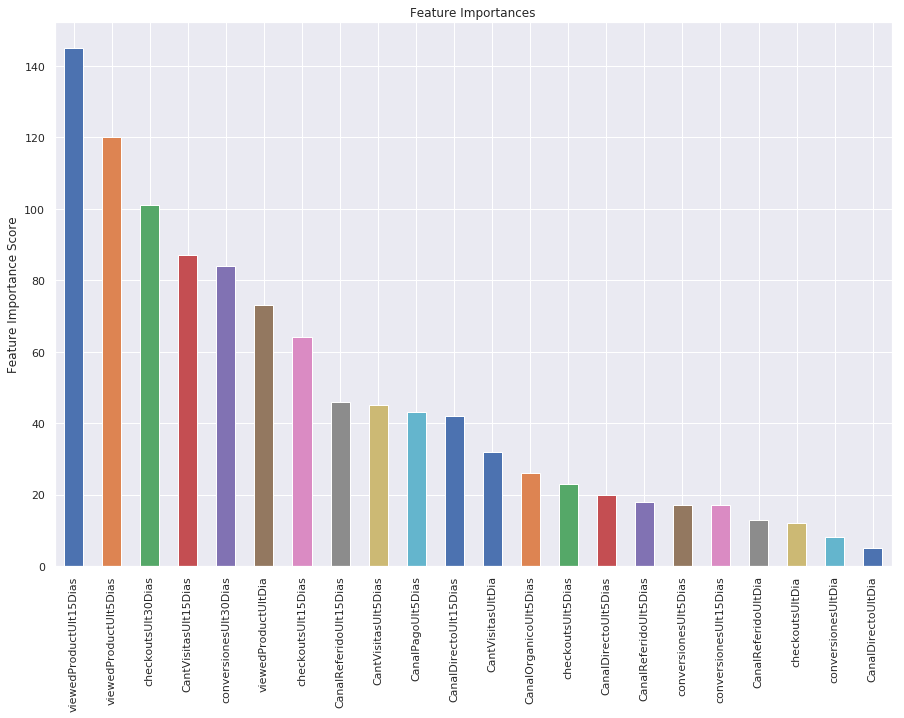

In [122]:
proba, testeo = train_test_split(dfPredictorLocal, test_size=0.2, random_state=123)
predictors = [x for x in proba.columns if x != 'label']

xgb1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 random_state=27)

modelfit(xgb1, proba, predictors)

In [125]:
testeoFeat, testeoLab = testeo.iloc[:,:-1], testeo.iloc[:,-1:]
predsa = xgb1.predict(testeoFeat)
roc_auc_score(testeoLab, predsa)#[:,1])

0.85329453406847733

<Figure size 1440x720 with 0 Axes>

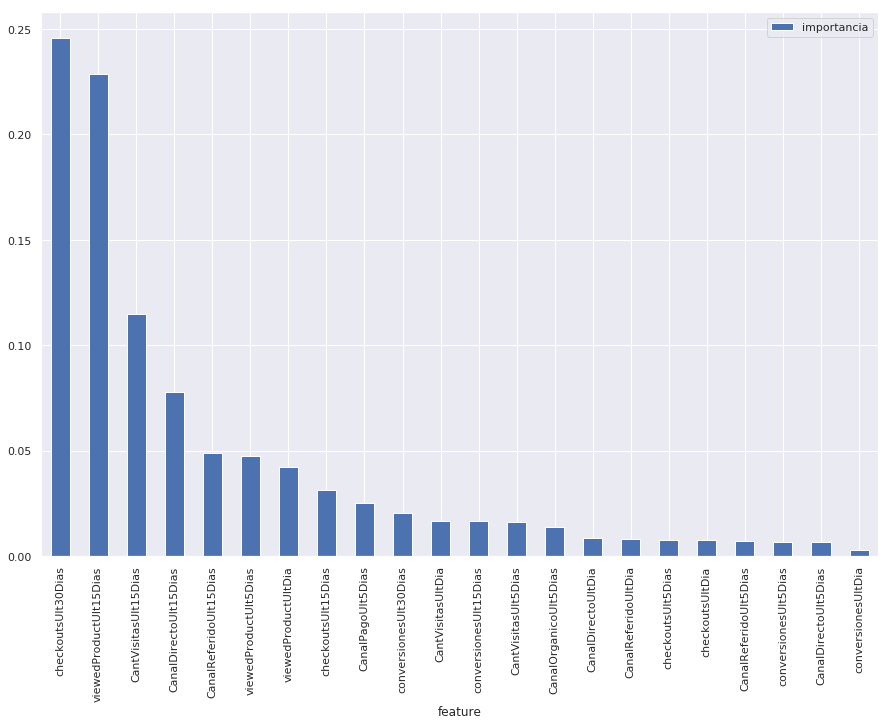

<Figure size 1440x720 with 0 Axes>

In [118]:
from sklearn.ensemble import RandomForestRegressor
#Load boston housing dataset as an example
names = X.columns
rf = RandomForestRegressor()
rf.fit(X.values, y.values.ravel())
impor = np.vstack((names, rf.feature_importances_)).T
imporDf = pd.DataFrame(impor)
imporDf.columns = ['feature', 'importancia']
imporDf = imporDf.set_index('feature').sort_values(by=['importancia'], ascending=False)
imporDf.plot(kind='bar')
plt.figure(figsize=(20,10))